In [11]:
import pandas as pd
import numpy as np
import scipy as sp
import os
import json
import pprint
%matplotlib inline
import tweepy
import networkx as nx
import random
from pyvis.network import Network
from functions_file import *
data_folder = "data"
print("imported completed! ")

imported completed! 


In [2]:
consumer_key = "ilMCDSvsK2gQPzNpExcN9w0dj"
consumer_secret = "LJhNjYbJwHOcmzihgJDsaVIdYxgkCF3aezr4v1k9pQkoH9mmgl"
access_token = "426038638-16YAVtywETEPoD9F1M5P6I3IavaZwRUF3RdjVTGd"
access_secret = "n0G7Hddsjm9HAFvvNY1ntNQk475PUTJg4Ub8F1x6k8ozn"
bearer_token = "AAAAAAAAAAAAAAAAAAAAAPUTJQEAAAAA8%2FTr01XqXtQ7NcaRUgtKtK2M%2BR0%3D7AByu1bjwYdcf0Xs7mOeVb6FKNCYEIW4VN16WMrB7CO7G1xXxU"

In [3]:
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)
api = tweepy.API(auth, wait_on_rate_limit = True, wait_on_rate_limit_notify = True)
if api.verify_credentials :
  print ('Authentication completed successfully!')

Authentication completed successfully!


In [13]:
users = ["lucabazzetto","Tomve99"]
#usersID = usersID(users)
quantity = 4
followers = {}
for user in users:
    followers_of_user = []
    for follow in tweepy.Cursor(
        api.followers,
        screen_name = user,
        skip_status=True,
        include_user_entities = False
    ).items(quantity):
        json_data = follow._json
        if json_data not in followers_of_user:
            followers_of_user.append(json_data["screen_name"])
    followers[user] = followers_of_user
serialize_json(data_folder,"followersLucaThomas.json", followers)

Data serialized to path: data/followersLucaThomas.json


In [12]:
users = ["lucabazzetto","Tomve99"]
quantity = 4
friends = {}
for user in users:
    friends_of_user = []
    for friend in tweepy.Cursor(
        api.friends,
        screen_name = user,
        skip_status=True,
        include_user_entities = False
    ).items(quantity):
        json_data = friend._json
        friends_of_user.append(friend._json["screen_name"])
    friends[user] = friends_of_user
serialize_json(data_folder,"friendsLucaThomas.json", friends)

Data serialized to path: data/friendsLucaThomas.json


In [5]:

def random_json_with_control(json_array, quantity, all):
    a = quantity
    array = []
    while(a!=0):
        item = random.choice(json_array)
        if item not in array and item not in all:
            array.append(item)
            a = a-1
    return array

followersALL = read_json(f"{data_folder}/followersLucaThomas.json")
fiveFollowers = []

# Estraggo per ogni utente 5 followers
for user in followersALL:
    fiveFollowers.extend(random_json_with_control(followersALL[user], 1, fiveFollowers))

quantity = 2
followersOfFollowers = {}

for user in fiveFollowers:
    followers_of_user = []
    for follower in tweepy.Cursor(
        api.followers,
        screen_name = user,
        skip_status=True,
        include_user_entities = False
    ).items(quantity):
        json_data = follower._json
        followers_of_user.append(follower._json["screen_name"])
    followersOfFollowers[user] = followers_of_user

serialize_json(data_folder,"followersOfFollowers.json", followersOfFollowers)

Data read fron path: data/followersLucaThomas.json
Data serialized to path: data/followersOfFollowers.json


In [6]:
friendsALL = read_json(f"{data_folder}/friendsLucaThomas.json")
fiveFriends = []

# Estraggo per ogni utente 5 followers
for user in friendsALL:
    fiveFriends.extend(random_json_with_control(friendsALL[user], 2, fiveFriends))

quantity = 2
friendsOfFriends = {}
for user in fiveFriends:
    friends_of_user = []
    for friend in tweepy.Cursor(
        api.friends,
        screen_name = user,
        skip_status=True,
        include_user_entities = False
    ).items(quantity):
        json_data = friend._json
        friends_of_user.append(friend._json["screen_name"])
    friendsOfFriends[user] = friends_of_user
serialize_json(data_folder,"friendsOfFriends.json", friendsOfFriends)

Data read fron path: data/friendsLucaThomas.json
Data serialized to path: data/friendsOfFriends.json


In [7]:
allFriends = {}
allFriends.update(read_json(f"{data_folder}/friendsOfFriends.json"))
allFriends.update(read_json(f"{data_folder}/followersOfFollowers.json"))
allFriends.update(read_json(f"{data_folder}/followersLucaThomas.json"))
allFriends.update(read_json(f"{data_folder}/friendsLucaThomas.json"))
#serialize_json(data_folder,"allFriends.json", allFriends)
#pprint.PrettyPrinter().pprint(allFriends)

vector = []
for (k,v) in allFriends.items():
    for item in v:
        if item not in vector:
            vector.append(item)

serialize_json(data_folder,"NODUPLICATI.json", vector)

puntoQuattro = {}

for user in vector:
    json_data = api.get_user(user)._json
    foundInfo = {}
    foundInfo ["id"] = json_data["id"]
    foundInfo ["name"] = json_data["name"]
    foundInfo ["screen_name"] = json_data["screen_name"]
    foundInfo ["location"] = json_data["location"]
    foundInfo ["followers_count"] = json_data["followers_count"]
    foundInfo ["friends_count"] = json_data["friends_count"]
    puntoQuattro[user] = foundInfo
serialize_json(data_folder,"puntoQuattro.json", puntoQuattro)

Data read fron path: data/friendsOfFriends.json
Data read fron path: data/followersOfFollowers.json
Data read fron path: data/followersLucaThomas.json
Data read fron path: data/friendsLucaThomas.json
Data serialized to path: data/NODUPLICATI.json
Data serialized to path: data/puntoQuattro.json


In [7]:
def get_friendship(sourceid, targetid, api):
    friendship = api.show_friendship(source_screen_name=sourceid, target_screen_name=targetid)
    dictio = {"source_id":sourceid,"targe_id":targetid,"relation":"no"}
    if friendship[0].followed_by:
        dictio["relation"] = "targetToSource"
    if friendship[0].following:
        dictio["relation"] = "SourceToTarget"
    return dictio

files = read_json(f"{data_folder}/NODUPLICATI.json")
prova = []
for source in files:
    for target in files:
        if source != target:
            prova.append(get_friendship(source,target,api))

"""
pp = pprint.PrettyPrinter()
pp.pprint(prova)

serialize_json(data_folder,"prova.json", prova)
graph = nx.DiGraph()
graph.add_nodes_from("files")

allDataPoint4 = read_json(f"{data_folder}/puntoQuattro.json")
graph = nx.DiGraph()
graph.add_nodes_from(allDataPoint4)
graph.graph["members"] = ["Luca","Thomas","Agustin","Edoardo"]

for user in allDataPoint4:
    for user2 in allDataPoint4:
        friendship = api.show_friendship(source_screen_name = user,target_screen_name = user2)
        if friendship[0].followed_by:
            graph.add_edge(user2,user)
        if friendship[0].following:
            graph.add_edge(user,user2)

nx.write_gpickle(graph,"data/graph.pkl")
"""

Data read fron path: data/NODUPLICATI.json


'\npp = pprint.PrettyPrinter()\npp.pprint(prova)\n\nserialize_json(data_folder,"prova.json", prova)\ngraph = nx.DiGraph()\ngraph.add_nodes_from("files")\n\nallDataPoint4 = read_json(f"{data_folder}/puntoQuattro.json")\ngraph = nx.DiGraph()\ngraph.add_nodes_from(allDataPoint4)\ngraph.graph["members"] = ["Luca","Thomas","Agustin","Edoardo"]\n\nfor user in allDataPoint4:\n    for user2 in allDataPoint4:\n        friendship = api.show_friendship(source_screen_name = user,target_screen_name = user2)\n        if friendship[0].followed_by:\n            graph.add_edge(user2,user)\n        if friendship[0].following:\n            graph.add_edge(user,user2)\n\nnx.write_gpickle(graph,"data/graph.pkl")\n'

In [ ]:
#GRAFO ORIENTATO
allDataPoint4 = read_json(f"{data_folder}/puntoQuattro.json")
graph = nx.DiGraph()
graph.add_nodes_from(allDataPoint4)

graph.graph["members"] = ["Luca","Thomas","Agustin","Edoardo"]

for user in allDataPoint4:
    for user2 in allDataPoint4:
        friendship = api.show_friendship(source_screen_name = user,target_screen_name = user2)
        if friendship[0].followed_by:
            graph.add_edge(user2,user)
        if friendship[0].following:
            graph.add_edge(user,user2)

nx.write_gpickle(graph,"data/graphOriented.pkl")

In [ ]:
#GRAFO NON ORIENTATO
allDataPoint4 = read_json(f"{data_folder}/puntoQuattro.json")
graph = nx.Graph()
graph.add_nodes_from(allDataPoint4)

graph.graph["members"] = ["Luca","Thomas","Agustin","Edoardo"]

for user in allDataPoint4:
    for user2 in allDataPoint4:
        friendship = api.show_friendship(source_screen_name = user,target_screen_name = user2)
        if friendship[0].followed_by | friendship[0].following:
            graph.add_edge(user,user2)

nx.write_gpickle(graph,"data/graphNoOriented.pkl")

In [ ]:
graph = nx.read_gpickle("data/graphNoOriented.pkl")
nt = Network(
    height="100%",
    width="100%",
    bgcolor="222222",
    font_color="white",
    heading="progetto"
)
nt.barnes_hut()
nt.from_nx(graph)
neighbor_map = nt.get_adj_list()
for node in nt.nodes:
    node["Value"] = len(neighbor_map[node['id']])
nt.show("grafico.html")

In [ ]:
username = "lucabazzetto"
quantity = 10
AllUsers = {}
dataOfUser = []
for follower in tweepy.Cursor(
    api.followers,
    screen_name = username,
    skip_status=True,
    include_user_entities = False
).items(quantity):
    dataOfUser.append(follower._json["screen_name"])

for friend in tweepy.Cursor(
    api.friends,
    screen_name = username,
    skip_status=True,
    include_user_entities = False
).items(quantity):
    jsonData = friend._json["screen_name"]
    if jsonData not in dataOfUser:
        dataOfUser.append(jsonData)

AllUsers[username] = dataOfUser
serialize_json(data_folder,"lucabazzettoALL.json", AllUsers)

In [ ]:
#punto 7
from networkx.algorithms.distance_measures import center

noOriented = nx.read_gpickle("data/graphNoOriented.pkl")
oriented = nx.read_gpickle("data/graphOriented.pkl")
if(nx.is_connected(noOriented)):
    print("Grafo connesso"),
    print("Centro: ", end=" ")
    print(nx.center(noOriented))
    print("Diametro: ", end=" ")
    print(nx.diameter(noOriented))
    print("Raggio: ", end=" ")
    print(nx.radius(noOriented))
    
    
else:
    print("Grafo non connesso")
    
if(nx.is_bipartite(noOriented)):
    print("Grafo bipartito")
else:
    print("Grafo non bipartito")
    

    
 #la centralità del mezzo è una misura della centralità in un grafico basato sui percorsi più brevi
print("Centralità del mezzo: ", end=" ")
print(nx.betweenness_centrality(noOriented))
print(" ")
print("Centralità della vicinanza: ", end=" ")
print(nx.closeness_centrality(noOriented))
print(" ")
print("Centralità di grado: ", end=" ")
print(nx.degree_centrality(noOriented))
print(" ")

print("In-degree centrality: ", end=" ")
print(nx.in_degree_centrality(oriented))
print(" ")
print("Out-degree centrality: ", end=" ")
print(nx.out_degree_centrality(oriented))
print(" ")
#Da vedere se bisogna modificare alpha (non so cosa sia) e altri parametri
print("Page Rank: ", end=" ")
print(nx.pagerank(oriented))
print(" ")
#Vengono ripetuti 2 volte i dati
print("HITS: ", end=" ")
print(nx.hits(noOriented))

In [ ]:
#Provo a disegnarlo (non scritto nella consegna)
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 10,10

nx.draw_networkx(
    oriented,
    pos = nx.spring_layout(oriented),
    node_color = "#FF0000",
    width = 2,
    edge_cmap = plt.cm.Blues,
    with_labels = True
)
plt.show()
plt.close()


In [ ]:
#punto 10 (non richiesto il disegno)

oriented = nx.read_gpickle("data/graphOriented.pkl")
tomve99 = nx.ego_graph(oriented, "Tomve99", radius=1)

nx.draw_networkx(
    tomve99,
    pos = nx.spring_layout(tomve99),
    node_color = "#FF0000",
    edge_color = "#A9A9A9",
    width = 2,
    edge_cmap = plt.cm.Blues,
    with_labels = True
)
plt.savefig("data/tomve99.pdf")
plt.show()
plt.close()

In [ ]:
#punto 10b-c
from networkx.algorithms.approximation import clique
clique.max_clique(tomve99)
#nx.sigma(tomve99)

Data read fron path: data/puntoQuattro.json


In [27]:
#GRAFO NON ORIENTATO
allDataPoint4 = read_json(f"{data_folder}/puntoQuattro.json")
graph = nx.Graph()
graph.add_nodes_from(allDataPoint4)

#graph.graph["members"] = ["Luca","Thomas","Agustin","Edoardo"]

for user in allDataPoint4:
    for user2 in allDataPoint4:
        friendship = api.show_friendship(source_screen_name = user,target_screen_name = user2)
        if friendship[0].followed_by | friendship[0].following:
            graph.add_edge(user,user2)

nx.write_gpickle(graph,"data/graphNoOriented.pkl")

Data read fron path: data/puntoQuattro.json


Rate limit reached. Sleeping for: 10


In [15]:
graph = nx.read_gpickle("data/graphNoOriented.pkl")
nt = Network(
    height="100%",
    width="100%",
    bgcolor="222222",
    font_color="white",
    heading="progetto"
)
nt.barnes_hut()
nt.from_nx(graph)
neighbor_map = nt.get_adj_list()
for node in nt.nodes:
    node["Value"] = len(neighbor_map[node['id']])
nt.show("grafico.html")

In [ ]:
#SE SI PUò ELIMINARE, ELIMINA
username = "lucabazzetto"
quantity = 10
AllUsers = {}
dataOfUser = []
for follower in tweepy.Cursor(
    api.followers,
    screen_name = username,
    skip_status=True,
    include_user_entities = False
).items(quantity):
    dataOfUser.append(follower._json["screen_name"])

for friend in tweepy.Cursor(
    api.friends,
    screen_name = username,
    skip_status=True,
    include_user_entities = False
).items(quantity):
    jsonData = friend._json["screen_name"]
    if jsonData not in dataOfUser:
        dataOfUser.append(jsonData)

AllUsers[username] = dataOfUser
serialize_json(data_folder,"lucabazzettoALL.json", AllUsers)

Data serialized to path: data/lucabazzettoALL.json


In [ ]:
#punto 7
from networkx.algorithms.distance_measures import center

noOriented = nx.read_gpickle("data/graphNoOriented.pkl")
oriented = nx.read_gpickle("data/graphOriented.pkl")
if(nx.is_connected(noOriented)):
    print("Grafo connesso"),
    print("Centro: ", end=" ")
    print(nx.center(noOriented))
    print("Diametro: ", end=" ")
    print(nx.diameter(noOriented))
    print("Raggio: ", end=" ")
    print(nx.radius(noOriented))
    
    
else:
    print("Grafo non connesso")
    
if(nx.is_bipartite(noOriented)):
    print("Grafo bipartito")
else:
    print("Grafo non bipartito")
    

    
 #la centralità del mezzo è una misura della centralità in un grafico basato sui percorsi più brevi
print("Centralità del mezzo: ", end=" ")
print(nx.betweenness_centrality(noOriented))
print(" ")
print("Centralità della vicinanza: ", end=" ")
print(nx.closeness_centrality(noOriented))
print(" ")
print("Centralità di grado: ", end=" ")
print(nx.degree_centrality(noOriented))
print(" ")

print("In-degree centrality: ", end=" ")
print(nx.in_degree_centrality(oriented))
print(" ")
print("Out-degree centrality: ", end=" ")
print(nx.out_degree_centrality(oriented))
print(" ")
#Da vedere se bisogna modificare alpha (non so cosa sia) e altri parametri
print("Page Rank: ", end=" ")
print(nx.pagerank(oriented))
print(" ")
#Vengono ripetuti 2 volte i dati
print("HITS: ", end=" ")
print(nx.hits(noOriented))

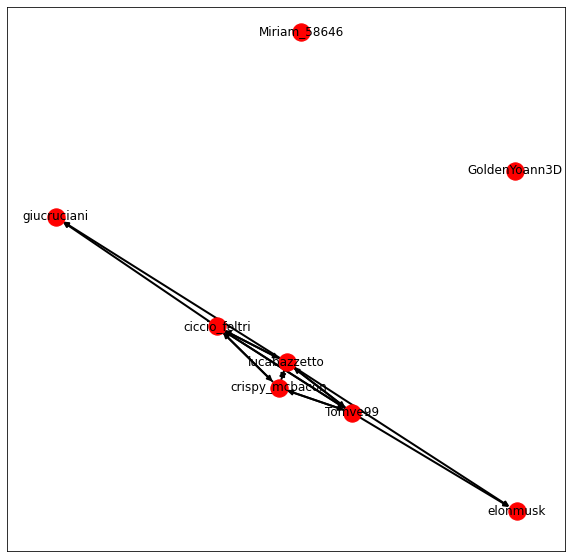

In [42]:
#Provo a disegnarlo (non scritto nella consegna)
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 10,10

nx.draw_networkx(
    oriented,
    pos = nx.spring_layout(oriented),
    node_color = "#FF0000",
    width = 2,
    edge_cmap = plt.cm.Blues,
    with_labels = True
)
plt.show()
plt.close()


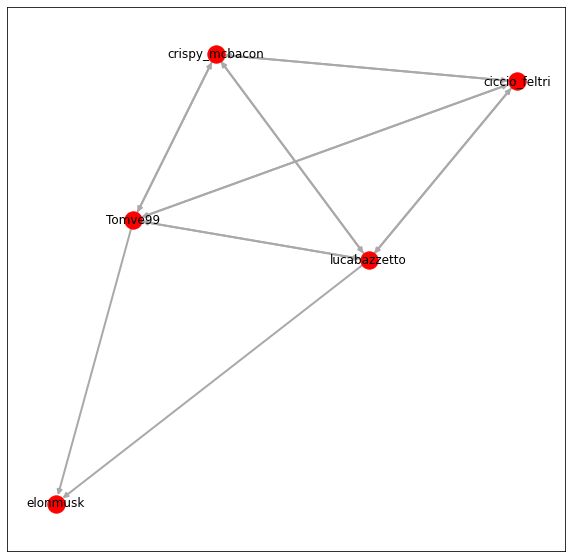

In [39]:
#punto 10 (non richiesto il disegno)

oriented = nx.read_gpickle("data/graphOriented.pkl")
tomve99 = nx.ego_graph(oriented, "Tomve99", radius=1)

nx.draw_networkx(
    tomve99,
    pos = nx.spring_layout(tomve99),
    node_color = "#FF0000",
    edge_color = "#A9A9A9",
    width = 2,
    edge_cmap = plt.cm.Blues,
    with_labels = True
)
plt.savefig("data/tomve99.pdf")
plt.show()
plt.close()

In [49]:
#punto 10b-c
from networkx.algorithms.approximation import clique
clique.max_clique(tomve99)
#nx.sigma(tomve99)

{'Tomve99', 'ciccio_feltri', 'crispy_mcbacon', 'lucabazzetto'}